In [1]:
import os
import shutil

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import thejoker as tj
import tables as tb
from schwimmbad import MultiPool

from hq.config import Config
from hq.data import get_rvdata

from scipy.stats import truncnorm as _truncnorm
def truncnorm(mu, sigma, clip_a, clip_b):
    a, b = (clip_a-mu)/sigma, (clip_b-mu)/sigma
    return _truncnorm(loc=mu, scale=sigma, a=a, b=b)

In [2]:
with MultiPool() as pool:
    pool_size = pool.size

In [3]:
def fast_m2_min(m1, mf):
    return (2*mf + np.power(2,0.6666666666666666)*
      np.power(mf*(27*pow(m1,2) + 18*m1*mf + 2*np.power(mf,2) + 
          3*np.sqrt(3)*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf))),0.3333333333333333) + 
     (2*mf*(6*m1 + mf))/
      np.power((27*np.power(m1,2)*mf)/2. + 9*m1*np.power(mf,2) + np.power(mf,3) + 
        (3*np.sqrt(3)*mf*np.sqrt(np.power(m1,3)*(27*m1 + 4*mf)))/2.,0.3333333333333333))/6.

In [4]:
c = Config.from_run_name('dr16-random')

In [5]:
allstar, allvisit = c.load_alldata()

---

In [6]:
metadata = at.QTable.read(c.metadata_path)

APW cross-match to Gaia from 2MASS ID:

In [7]:
if not os.path.exists('../catalogs/dr16_gaia_starhorse_metadata.fits'):
    gaia = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allStar-r12-gaiadr2.fits')
    _, idx = np.unique(gaia['apogee_id'], return_index=True)
    gaia = gaia[idx]
    gaia.rename_column('apogee_id', 'APOGEE_ID')

    for col in gaia.colnames:
        gaia[col].unit = None

    master = at.join(master, gaia, keys='APOGEE_ID')

    # Stellar masses from StarHorse2019: https://data.aip.de/projects/starhorse2019.html

    tbl = at.Table()
    tbl['source_id'] = np.load('/mnt/home/apricewhelan/data/starhorse/all-source_id.npz')['arr_0']
    tbl['mass'] = np.load('/mnt/home/apricewhelan/data/starhorse/all-mass50.npz')['arr_0']

    err1 = tbl['mass'] - np.load('/mnt/home/apricewhelan/data/starhorse/all-mass16.npz')['arr_0']
    err2 = np.load('/mnt/home/apricewhelan/data/starhorse/all-mass84.npz')['arr_0'] - tbl['mass']
    tbl['mass_err'] = np.max([err1, err2], axis=0)

    pre_idx = np.isin(tbl['source_id'], master['source_id'])

    print(len(master))
    master = at.join(metadata, allstar, keys='APOGEE_ID')
    master = at.join(master, tbl[pre_idx], keys='source_id', join_type='left')
    master['mass'] = master['mass'].filled(np.nan)
    print(len(master))

    master.write('../catalogs/dr16_gaia_starhorse_metadata.fits', overwrite=True)

In [8]:
master = at.QTable.read('../catalogs/dr16_gaia_starhorse_metadata.fits')

In [9]:
len(master)

231220

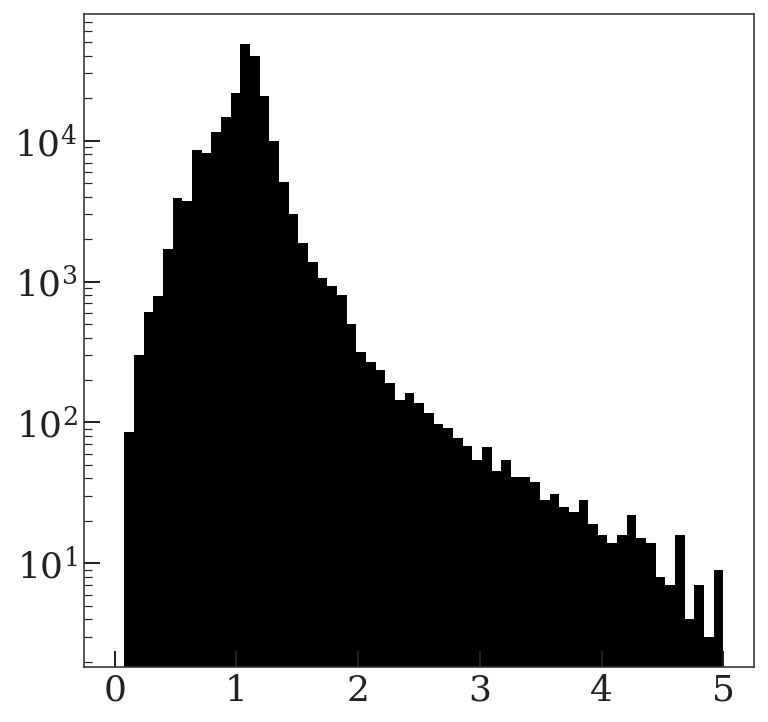

In [10]:
plt.hist(master['mass'], bins=np.linspace(0, 5, 64));
plt.yscale('log')

### Now load stars that pass the evidence ratio cut:

In [11]:
name = 'lnK0.0_logL4.6'

In [12]:
all_samples = at.Table.read(f'../catalogs/{name}_samples.hdf5')
all_samples['APOGEE_ID'] = all_samples['APOGEE_ID'].astype(str)
len(all_samples)

9425259

In [13]:
master_cut = master[np.isin(master['APOGEE_ID'], all_samples['APOGEE_ID'])
                    & np.isfinite(master['mass'])]
len(master_cut)

17682

In [14]:
from thejoker.multiproc_helpers import batch_tasks
tasks = batch_tasks(len(master_cut), pool_size, arr=master_cut)

In [16]:
percentiles = [1, 5, 16, 50, 84, 95, 99]

In [18]:
def worker(task):
    rows, id_ = task
    
    tmp = []
    m2_mins = dict()
    for row in rows:
        samples = all_samples[all_samples['APOGEE_ID'] == row['APOGEE_ID']]

        if len(samples) < 10:
            n_m1 = 128
        else:
            n_m1 = 4

        m1_samples = truncnorm(row['mass'], row['mass_err'], 0, 1e2).rvs(size=(len(samples), n_m1)).ravel() * u.Msun
        mf = np.repeat(samples['m_f'][:, None], n_m1, axis=1).ravel() * u.Msun
        # m2_min = get_m2_min(m1_samples, mf)
        m2_min = fast_m2_min(m1_samples.value, mf.value)
        tmp.append(np.nanpercentile(m2_min, percentiles))
        m2_mins[row['APOGEE_ID']] = m2_min
        
    return tmp, m2_mins

In [19]:
m2_min_percentiles = []
all_m2_min = dict()
with MultiPool() as pool:
    for perc, allvals in pool.map(worker, tasks):
        m2_min_percentiles.append(perc)
        all_m2_min.update(allvals)
        
m2_min_percentiles = np.array([l for x in m2_min_percentiles for l in x ])

/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [20]:
for i, val in enumerate(percentiles):
    master_cut[f'm2_min_{val}'] = m2_min_percentiles[:, i] * u.Msun

In [21]:
master_cut.write(f'../catalogs/{name}_metadata_gaia_starhorse.fits', overwrite=True)

In [22]:
((master_cut['m2_min_95'] < 0.1*u.Msun) & (master_cut['n_visits'] >= 5)).sum()

657

In [23]:
(master_cut['m2_min_5'] > 1.5*u.Msun).sum()

47

In [24]:
((master_cut['m2_min_5'] > 1.5*u.Msun) & (master_cut['m2_min_5'] > master_cut['mass']*u.Msun)).sum()

34